# Transfer labels from annotated single-cell to spatial transcriptomics

This tutorial demonstrates how to transfer labels from an annotated dataset to another dataset of similar cell types using LANTSA.

We will use an annotated single-cell transcriptomics dataset comprised of cells sampled from multiple cortical areas, originally provided by the [Allen Institute](https://www.nature.com/articles/nn.4216) and preprocessed by [Seurat](https://satijalab.org/seurat/articles/spatial_vignette.html), with 14,249 cells and 23 annotated clusters sequenced using SMART-Seq2 protocol, which can be downloaded [here](https://www.dropbox.com/s/cuowvm4vrf65pvq/allen_cortex.rds?dl=1). The annotated labels will be transferred to a sub-assay of 10x Visium *Mouse Brain Serial Section 1 (Sagittal-Anterior)* dataset, which is publicly available from the 10x genomics website: [link](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Mouse_Brain_Sagittal_Anterior).

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import lantsa

## Read the data

We have preprocessed these two datasets, which is now ready for label transfer. The preprocessed datasets are distributed in [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) (`.h5ad`) format, which can be downloaded [here](https://www.dropbox.com/sh/88cx4mvjcu0hrvo/AAC9GV5p6N43nsqaFP9YWTy5a?dl=0).

In [2]:
adata_learning = sc.read_h5ad('./data/scRNA_cortex_learning_topGenes2000.h5ad')
adata_learning

AnnData object with n_obs × n_vars = 14249 × 2000
    obs: 'age_days', 'brain_hemisphere', 'brain_region', 'brain_subregion', 'class', 'cluster', 'cluster_correlation', 'complexity_cg', 'confusion_score', 'core_intermediate_call', 'donor', 'driver_lines', 'eye_condition', 'facs_container', 'facs_date', 'facs_sort_criteria', 'genes_detected_cpm_criterion', 'genes_detected_fpkm_criterion', 'genotype', 'gfp_cpm', 'injection_exclusion_criterion', 'injection_label_direction', 'injection_material', 'injection_primary', 'injection_secondary', 'injection_tract', 'library_prep_avg_size_bp', 'library_prep_set', 'nCount_RNA', 'nFeature_RNA', 'organism', 'orig.ident', 'percent_aligned_reads_total', 'percent_ecoli_reads', 'percent_exon_reads', 'percent_intergenic_reads', 'percent_intron_reads', 'percent_mt_exon_reads', 'percent_reads_unique', 'percent_rrna_reads', 'percent_synth_reads', 'reporter_lines', 'rna_amplification_set', 'sample_id', 'sample_type', 'seq_batch', 'seq_name', 'seq_tube', 'sex'

In [3]:
adata_prediction = sc.read_h5ad('./data/Sagittal_Anterior_prediction_topGenes2000.h5ad')
adata_prediction

AnnData object with n_obs × n_vars = 1078 × 2000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Transfer labels

Then, we concatenate them into an assembled object `adata` for label transfer.

In [4]:
adata = adata_learning.concatenate(adata_prediction, index_unique=None)
adata.obs['is_learning'] = adata.obs['batch'] == '0'
adata.uns = adata_learning.uns
adata

AnnData object with n_obs × n_vars = 15327 × 2000
    obs: 'age_days', 'brain_hemisphere', 'brain_region', 'brain_subregion', 'class', 'cluster', 'cluster_correlation', 'complexity_cg', 'confusion_score', 'core_intermediate_call', 'donor', 'driver_lines', 'eye_condition', 'facs_container', 'facs_date', 'facs_sort_criteria', 'genes_detected_cpm_criterion', 'genes_detected_fpkm_criterion', 'genotype', 'gfp_cpm', 'injection_exclusion_criterion', 'injection_label_direction', 'injection_material', 'injection_primary', 'injection_secondary', 'injection_tract', 'library_prep_avg_size_bp', 'library_prep_set', 'nCount_RNA', 'nFeature_RNA', 'organism', 'orig.ident', 'percent_aligned_reads_total', 'percent_ecoli_reads', 'percent_exon_reads', 'percent_intergenic_reads', 'percent_intron_reads', 'percent_mt_exon_reads', 'percent_reads_unique', 'percent_rrna_reads', 'percent_synth_reads', 'reporter_lines', 'rna_amplification_set', 'sample_id', 'sample_type', 'seq_batch', 'seq_name', 'seq_tube', 'sex'

Now, we transfer the annotated labels in the single-cell transcriptomics dataset to spatial transcriptomics dataset.

In [5]:
lantsa.transfer_labels(adata, adata_learning, groups='subclass', discriminant_dim=290)

## Visualization of transferred probability

We create a temporary object `adata_proba` storing the transferred probability for visualization.

In [6]:
adata_proba = sc.AnnData(pd.DataFrame(adata.uns['transfer_labels']['probability']))
adata_proba.obs_names = adata.obs_names
adata_proba = adata_proba[adata_prediction.obs_names, :]
adata_proba.obsm['spatial'] = adata_prediction.obsm['spatial']
adata_proba.uns['spatial'] = adata_prediction.uns['spatial']

C:\ProgramData\Anaconda3\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Now, we visualize the probability of 9 main cell types for each spot in spatial coordinates.

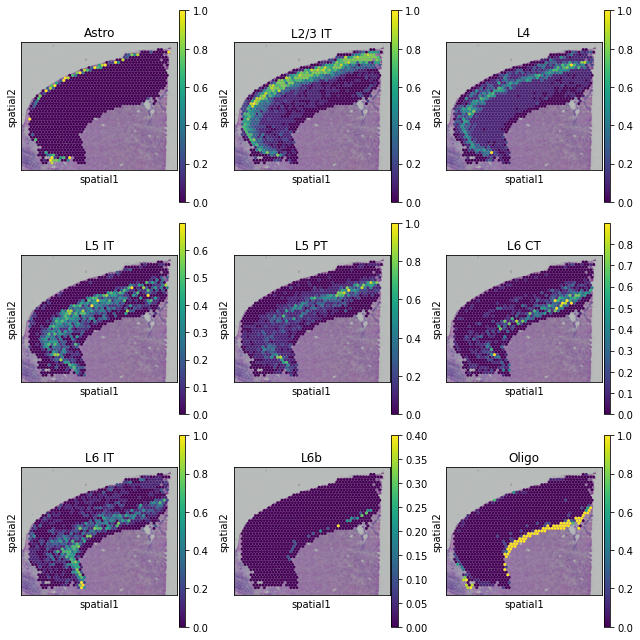

In [7]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

colors = ['Astro', 'L2/3 IT', 'L4', 'L5 IT', 'L5 PT', 'L6 CT', 'L6 IT', 'L6b', 'Oligo']

for idx in range(9):
    sc.pl.spatial(
        adata_proba,
        img_key='hires',
        color=colors[idx],
        size=1.5,
        palette=sc.pl.palettes.default_102,
        legend_loc='right margin',
        show=False,
        ax=axs[idx//3, idx%3],
    )

plt.tight_layout()